# Royal Weapons analysis

_Written by Bygdle#8333_

In this document i will try to analyse the passive effect of the Royal Series
weapons in order to get an accurate description of the effect it provides.

The idea is to make the description simple enough withouth losing accuracy,
and then add it to the calculator.

First, the original description of the effect:

> Upon damaging an opponent, increases CRIT Rate by 8/10/12/14/16%. 
> Max 5 stacks. A CRIT Hit removes all stacks.

While it could sound like a great buff to crit rate, the part of 
"A CRIT Hit removes all stacks" is the key here: each hit scored
has a chance to remove all stacks, and that chance increases
with the number of stacks. So, the higher stacks you have, the
higher the chance to lose them all. This, together with the fact
that the character's CRIT Rate also increases the chance to lose
all stacks, and discovering how this behaves is the main goal of
this analysis.

## 0. Setup
You can ignore this section, i'm just installing the libraries
i will use in this notebook. Skip to section 1.

In [31]:
%pip install numpy
%pip install matplotlib
%pip install sympy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [32]:
from random import random
import numpy as np
import matplotlib.pyplot as plt
from sympy import Matrix, symbols, solve, simplify

## 1. Analysis via random simulation

The idea is simple: simulate multiple hits with a given
crit rate, and for each hit, decide whether it's a crit or not,
and increase/reset the stacks accordingly. Then, calculate the
simulated crit rate by dividing the number of crits by the total.

In [33]:
# the random event function
def chance(p):
    '''
    Returns True with probability p, False with probability 1-p.
    '''
    return random() < p

### 1.1. Simulation

In [34]:
def royal_sim(r0, rank, n):
    '''
    Simulates the Royal passive for the given number of hits.
    r0: initial crit rate
    rank: refinement rank
    n: number of hits
    Returns the simulated crit rate.
    '''

    r = r0 # crit rate
    p = 0.08 + 0.02 *(rank - 1) # crit rate increase per stack

    crits = 0 # number of crits
    stacks = 0 # number of stacks

    for i in range(n):
        if chance(r): # crit hit scored
            crits += 1 # increment crits
            stacks = 0 # reset stacks
            r = r0     # reset crit rate
        elif stacks < 5: # crit hit missed but can still stack
            stacks += 1 # increment stacks
            r += p      # increment crit rate
    
    return crits / n



For example, if the crit rate is 50% and the refinement rank is 1,
the simulation would be as follows:

In [35]:
royal_sim(0.5, 1, 1000)

0.55

Note that the result of this simulation is **random** so it
will generate different results each time you run it.

### 1.2. Running the simulation with different values of crit rate and refinement rank

In [36]:
domain = np.arange(0, 1, 0.01) # values of r
results = {} # dictionary to store results
n = 100000   # number of hits to simulate

for rank in range(1, 6):
    label = f'rank {rank}' # label for the plot
    results[label] = [] # initialize list for results
    for r0 in domain: # iterate over r values
        p = royal_sim(r0, rank, n) # simulate crit rate
        p = p - r0 # what we want to know is the crit rate increase
        results[label].append(p)

Text(0, 0.5, 'Crit rate increase')

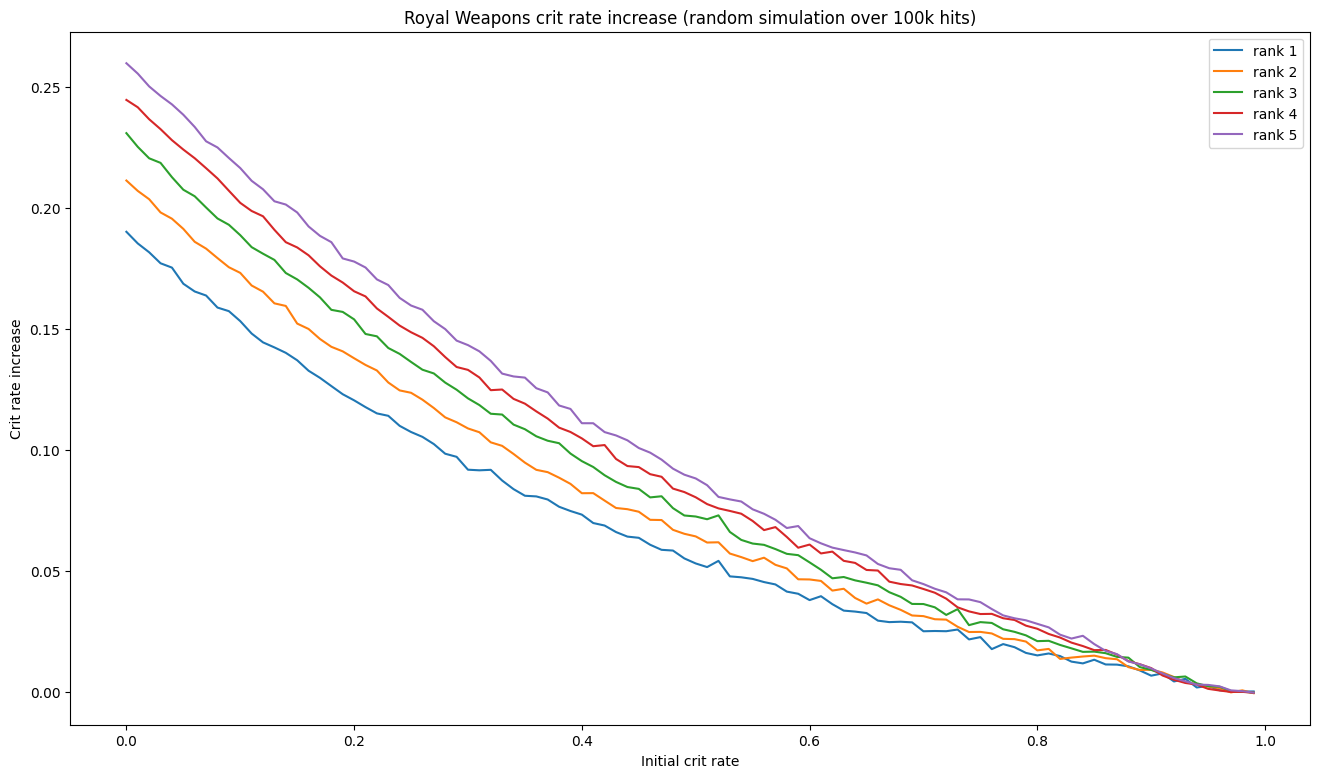

In [37]:
fig, ax = plt.subplots(figsize=(16, 9))
for label in results:
    ax.plot(domain, results[label], label=label)
ax.legend()
ax.set_title("Royal Weapons crit rate increase (random simulation over 100k hits)")
ax.set_xlabel("Initial crit rate")
ax.set_ylabel("Crit rate increase")

This gives us a rough estimation of the behavior of the Royal passive 
in terms of crit rate and refinement rank. However, an evident problem
with this method is that it's not very accurate and requires a lot of
time to run. A better approach is described in the next section.

## 2. Analysis using Markov Chains

This system can be described as a Markov Chain with 6 states,
each state representing a different number of stacks of the passive.

I will not explain in detail how Markov Chains work 
(read more at [the wiki](https://en.wikipedia.org/wiki/Markov_chain)),
but as a quick summary, a Markov Chain describes a system where
we have a set of states, and we can move from one state to another
with a given probability.


### 2.1. Modeling
In this case, the states are the number of stacks of the passive,
and the probability of moving from one state to another depends 
on the total CRIT Rate:

- if we have $i$ stacks, the probability of losing all stacks is
  equivalent to the CRIT Rate (the probability of scoring a crit).
- if we have $i$ stacks, the probability of gaining a stack is
  equivalent the complement of the CRIT Rate (the probability of
  not scoring a crit), including the crit rate given by the $i$ stacks.

The graphical representation of the Markov Chain is shown below.

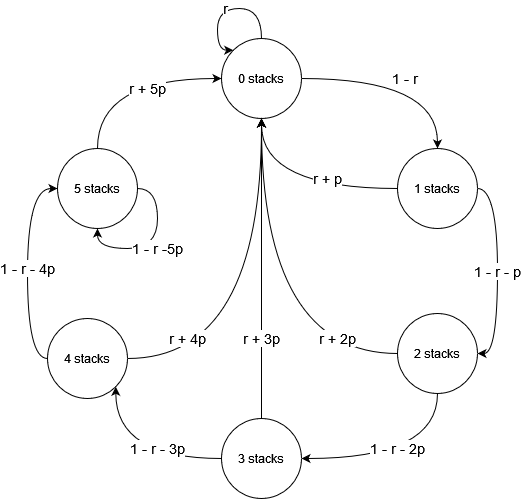

And the transition matrix $M$ as follows:

|#       |0 stacks|1 stacks|2 stacks |3 stacks  |4 stacks  |5 stacks  |
|--------|--------|--------|---------|----------|----------|----------|
|0 stacks|r       |1-r     |0        |0         |0         |0         |
|1 stacks|r + p   |0       |1 - r - p|0         |0         |0         |
|2 stacks|r + 2p  |0       |0        |1 - r - 2p|0         |0         |
|3 stacks|r + 3p  |0       |0        |0         |1 - r - 3p|0         |
|4 stacks|r + 4p  |0       |0        |0         |0         |1 - r - 4p|
|5 stacks|r + 5p  |0       |0        |0         |0         |1 - r -5p |

Where $r$ is th initial crit rate and $p$ is the passive crit rate increase per stack.

Let $P_i$ the probability vector of the chain at hit $i$, given by:

$$
P_i = \begin{bmatrix}
p_{i0} \\
p_{i1} \\
p_{i2} \\
p_{i3} \\
p_{i4} \\
p_{i5}
\end{bmatrix}
$$

Where $p_{ij}$ is the probability of having $j$ stacks at hit $i$.

The probability vector at hit $i+1$ is given by:

$$
P_{i+1} = P_i M
$$

### 2.2. Simulation of the transition states

In [38]:
def royal(r, p, n = 3):
    '''
    Computes the probability of being in each of the 6 states after n hits,
    given an initial crit rate of r and a crit rate increase per stack of p.
    '''
    # base transition matrix
    T = np.zeros((6, 6))

    # fill values in the leftmost column
    for i in range(6):
        T[i, 0] = r + i * p

    # fill values in the diagonal
    for i in range(5):
        T[i, i + 1] = 1 - r - i * p
    
    # fill values in the bottom right corner
    T[5, 5] = 1 - r - 5 * p

    # clamp matrix cells to [0, 1]
    T = np.clip(T, 0, 1)

    # Initial probability vector
    P = np.zeros(6)
    P[0] = 1

    # Compute the probability vector after n steps
    for i in range(n):
        P = P @ T
    return P


The resulting probability vector after $n$ hits corresponds
to the probability of having $i$ stacks after $n$ iterations.
For example, for $r = 0.5, p=0.08, n=10$, the probability vector
is the following:

In [39]:
royal(0.5, 0.08, 10)

array([0.55442358, 0.27721436, 0.11642962, 0.03958089, 0.01029156,
       0.00206   ])

Which means 0.554 chance of having 0 stacks, 0.277 of having 1 stack, and so on.

Now, we can find the crit rate's expected value by multiplying each probability
by the corresponding crit rate of the state, and summing the results.

In [40]:
P = royal(0.5, 0.08, 10)
sum(P[i] * (0.5 + i * 0.08) for i in range(6))

0.5544225999722188

Which gives us a crit rate's expected value of about 0.554.

### 2.3. Running the simulation for different values of $r$ and $p$

This calculation can be done for multiple values of initial crit rate,
and for each weapon refinement rank which changes the value of $p$.

In [41]:
domain = np.arange(0, 1, 0.01) # values of r
results = {} # dictionary to store results
n = 10 # number of hits

for rank in range(1, 6):
    label = f'rank {rank}' # label for the plot
    stack = 0.08 + 0.02*(rank - 1) # stack value per rank
    results[label] = [] # initialize list for results
    for r0 in domain: # iterate over r values
        P = royal(r0, stack, n) # compute probability vector
        p = sum(P[i] * (r0 + i * stack) for i in range(6)) # compute expected value
        p = p - r0 # what we want to know is the crit rate increase
        results[label].append(p)

Text(0, 0.5, 'Crit rate increase')

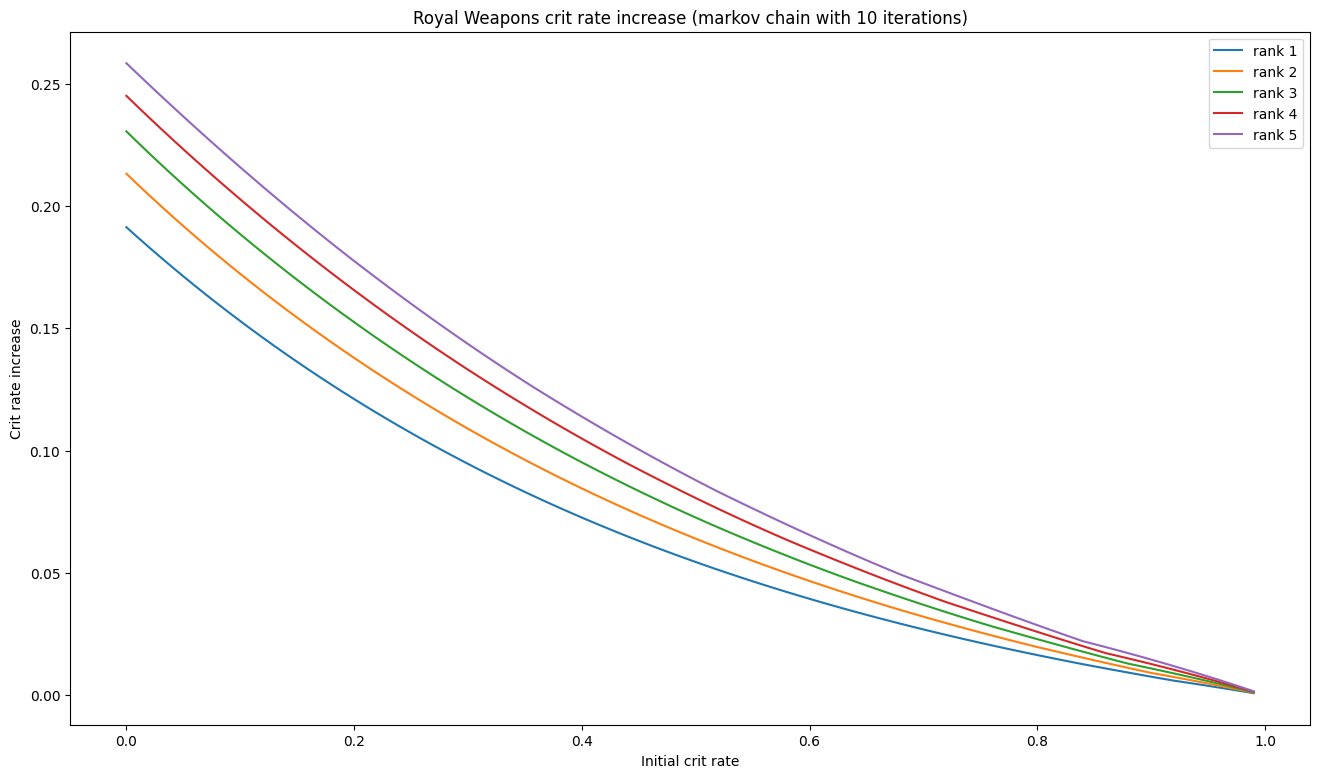

In [42]:
fig, ax = plt.subplots(figsize=(16, 9))
for label in results:
    ax.plot(domain, results[label], label=label)
ax.legend()

ax.set_title("Royal Weapons crit rate increase (markov chain with 10 iterations)")
ax.set_xlabel("Initial crit rate")
ax.set_ylabel("Crit rate increase")

### 2.4. Finding the steady state of the system

The steady state of the system is the probability vector that remains
constant after a certain number of iterations. This can be found by
solving the following equation:

$$
X = X M
$$

Where $X$ is the steady state probability vector. This means that,
even if we continue iterating the system, the probability vector will
remain the same (the system has reached a steady state).

Also, whe know that the sum of the probabilities of all states is 1, so:

$$
\sum_{i=0}^{5} X_i = 1
$$

To find this value, we will represent the transition matrix and the probability
vector symbolically, using the `sympy` library, and then solve the equation.

In [43]:
r, p = symbols('r p')
M = Matrix([
    [r, 1 - r, 0, 0, 0, 0],
    [r + p, 0, 1 - r - p, 0, 0, 0],
    [r + 2 * p, 0, 0, 1 - r - 2 * p, 0, 0],
    [r + 3 * p, 0, 0, 0, 1 - r - 3 * p, 0],
    [r + 4 * p, 0, 0, 0, 0, 1 - r - 4 * p],
    [r + 5 * p, 0, 0, 0, 0, 1 - r - 5 * p],
])

M

Matrix([
[      r, 1 - r,          0,            0,            0,            0],
[  p + r,     0, -p - r + 1,            0,            0,            0],
[2*p + r,     0,          0, -2*p - r + 1,            0,            0],
[3*p + r,     0,          0,            0, -3*p - r + 1,            0],
[4*p + r,     0,          0,            0,            0, -4*p - r + 1],
[5*p + r,     0,          0,            0,            0, -5*p - r + 1]])

In [44]:
x = symbols('x0:6')
X = Matrix(x).T
X

Matrix([[x0, x1, x2, x3, x4, x5]])

And now, solving the equation system we get:

In [45]:
# Steady state equation
eq1 = X - X*M
eq1

Matrix([[-r*x0 + x0 - x1*(p + r) - x2*(2*p + r) - x3*(3*p + r) - x4*(4*p + r) - x5*(5*p + r), -x0*(1 - r) + x1, -x1*(-p - r + 1) + x2, -x2*(-2*p - r + 1) + x3, -x3*(-3*p - r + 1) + x4, -x4*(-4*p - r + 1) - x5*(-5*p - r + 1) + x5]])

In [46]:
# Steady state probability sum must be 1
eq2 = sum(x) - 1
eq2

x0 + x1 + x2 + x3 + x4 + x5 - 1

In [47]:
solution = solve((eq1, eq2), x)
solution

{x0: (5*p + r)/(6*p**4*r - 6*p**4 + 11*p**3*r**2 - 26*p**3*r + 15*p**3 + 6*p**2*r**3 - 24*p**2*r**2 + 33*p**2*r - 15*p**2 + p*r**4 - 6*p*r**3 + 15*p*r**2 - 20*p*r + 15*p + 1),
 x1: (-5*p*r + 5*p - r**2 + r)/(6*p**4*r - 6*p**4 + 11*p**3*r**2 - 26*p**3*r + 15*p**3 + 6*p**2*r**3 - 24*p**2*r**2 + 33*p**2*r - 15*p**2 + p*r**4 - 6*p*r**3 + 15*p*r**2 - 20*p*r + 15*p + 1),
 x2: (5*p**2*r - 5*p**2 + 6*p*r**2 - 11*p*r + 5*p + r**3 - 2*r**2 + r)/(6*p**4*r - 6*p**4 + 11*p**3*r**2 - 26*p**3*r + 15*p**3 + 6*p**2*r**3 - 24*p**2*r**2 + 33*p**2*r - 15*p**2 + p*r**4 - 6*p*r**3 + 15*p*r**2 - 20*p*r + 15*p + 1),
 x3: (-10*p**3*r + 10*p**3 - 17*p**2*r**2 + 32*p**2*r - 15*p**2 - 8*p*r**3 + 21*p*r**2 - 18*p*r + 5*p - r**4 + 3*r**3 - 3*r**2 + r)/(6*p**4*r - 6*p**4 + 11*p**3*r**2 - 26*p**3*r + 15*p**3 + 6*p**2*r**3 - 24*p**2*r**2 + 33*p**2*r - 15*p**2 + p*r**4 - 6*p*r**3 + 15*p*r**2 - 20*p*r + 15*p + 1),
 x4: (30*p**4*r - 30*p**4 + 61*p**3*r**2 - 116*p**3*r + 55*p**3 + 41*p**2*r**3 - 112*p**2*r**2 + 101*p**2*r

Displaying the solution, we have:

In [48]:
for xi in x:
    display(xi, solution[xi])

x0

(5*p + r)/(6*p**4*r - 6*p**4 + 11*p**3*r**2 - 26*p**3*r + 15*p**3 + 6*p**2*r**3 - 24*p**2*r**2 + 33*p**2*r - 15*p**2 + p*r**4 - 6*p*r**3 + 15*p*r**2 - 20*p*r + 15*p + 1)

x1

(-5*p*r + 5*p - r**2 + r)/(6*p**4*r - 6*p**4 + 11*p**3*r**2 - 26*p**3*r + 15*p**3 + 6*p**2*r**3 - 24*p**2*r**2 + 33*p**2*r - 15*p**2 + p*r**4 - 6*p*r**3 + 15*p*r**2 - 20*p*r + 15*p + 1)

x2

(5*p**2*r - 5*p**2 + 6*p*r**2 - 11*p*r + 5*p + r**3 - 2*r**2 + r)/(6*p**4*r - 6*p**4 + 11*p**3*r**2 - 26*p**3*r + 15*p**3 + 6*p**2*r**3 - 24*p**2*r**2 + 33*p**2*r - 15*p**2 + p*r**4 - 6*p*r**3 + 15*p*r**2 - 20*p*r + 15*p + 1)

x3

(-10*p**3*r + 10*p**3 - 17*p**2*r**2 + 32*p**2*r - 15*p**2 - 8*p*r**3 + 21*p*r**2 - 18*p*r + 5*p - r**4 + 3*r**3 - 3*r**2 + r)/(6*p**4*r - 6*p**4 + 11*p**3*r**2 - 26*p**3*r + 15*p**3 + 6*p**2*r**3 - 24*p**2*r**2 + 33*p**2*r - 15*p**2 + p*r**4 - 6*p*r**3 + 15*p*r**2 - 20*p*r + 15*p + 1)

x4

(30*p**4*r - 30*p**4 + 61*p**3*r**2 - 116*p**3*r + 55*p**3 + 41*p**2*r**3 - 112*p**2*r**2 + 101*p**2*r - 30*p**2 + 11*p*r**4 - 38*p*r**3 + 48*p*r**2 - 26*p*r + 5*p + r**5 - 4*r**4 + 6*r**3 - 4*r**2 + r)/(6*p**4*r - 6*p**4 + 11*p**3*r**2 - 26*p**3*r + 15*p**3 + 6*p**2*r**3 - 24*p**2*r**2 + 33*p**2*r - 15*p**2 + p*r**4 - 6*p*r**3 + 15*p*r**2 - 20*p*r + 15*p + 1)

x5

(-24*p**4*r + 24*p**4 - 50*p**3*r**2 + 100*p**3*r - 50*p**3 - 35*p**2*r**3 + 105*p**2*r**2 - 105*p**2*r + 35*p**2 - 10*p*r**4 + 40*p*r**3 - 60*p*r**2 + 40*p*r - 10*p - r**5 + 5*r**4 - 10*r**3 + 10*r**2 - 5*r + 1)/(6*p**4*r - 6*p**4 + 11*p**3*r**2 - 26*p**3*r + 15*p**3 + 6*p**2*r**3 - 24*p**2*r**2 + 33*p**2*r - 15*p**2 + p*r**4 - 6*p*r**3 + 15*p*r**2 - 20*p*r + 15*p + 1)

We know that the state 0 has a crit rate of $r$, the state 1 has a 
crit rate of $r + p$, the state 2 has a crit rate of $r + 2p$, and so on.

So, the next step will be to calculate the crit rate's expected value

In [49]:
E = sum(solution[xi] * (r + i * p) for i, xi in enumerate(x))
E = simplify(E)
print(E)
E

(5*p + r)/(6*p**4*r - 6*p**4 + 11*p**3*r**2 - 26*p**3*r + 15*p**3 + 6*p**2*r**3 - 24*p**2*r**2 + 33*p**2*r - 15*p**2 + p*r**4 - 6*p*r**3 + 15*p*r**2 - 20*p*r + 15*p + 1)


(5*p + r)/(6*p**4*r - 6*p**4 + 11*p**3*r**2 - 26*p**3*r + 15*p**3 + 6*p**2*r**3 - 24*p**2*r**2 + 33*p**2*r - 15*p**2 + p*r**4 - 6*p*r**3 + 15*p*r**2 - 20*p*r + 15*p + 1)

Once the expression is simplified, let's test it against the
simulation results previously obtained.

In [50]:
def royal_expr(r, p):
    '''
    Computes the expected crit rate increase of Royal Weapons
    given an initial crit rate of r and a crit rate increase per stack of p.
    '''
    return (5*p + r)/(6*p**4*r - 6*p**4 + 11*p**3*r**2 - 26*p**3*r + 15*p**3 + 6*p**2*r**3 - 24*p**2*r**2 + 33*p**2*r - 15*p**2 + p*r**4 - 6*p*r**3 + 15*p*r**2 - 20*p*r + 15*p + 1)

In [51]:
domain = np.arange(0, 1, 0.01) # values of r
results = {} # dictionary to store results

for rank in range(1, 6):
    label = f'rank {rank}' # label for the plot
    stack = 0.08 + 0.02*(rank - 1) # stack value per rank
    results[label] = [] # initialize list for results
    for r0 in domain: # iterate over r values
        p = royal_expr(r0, stack) # compute probability
        p = p - r0 # what we want to know is the crit rate increase
        results[label].append(p)

Text(0, 0.5, 'Crit rate increase')

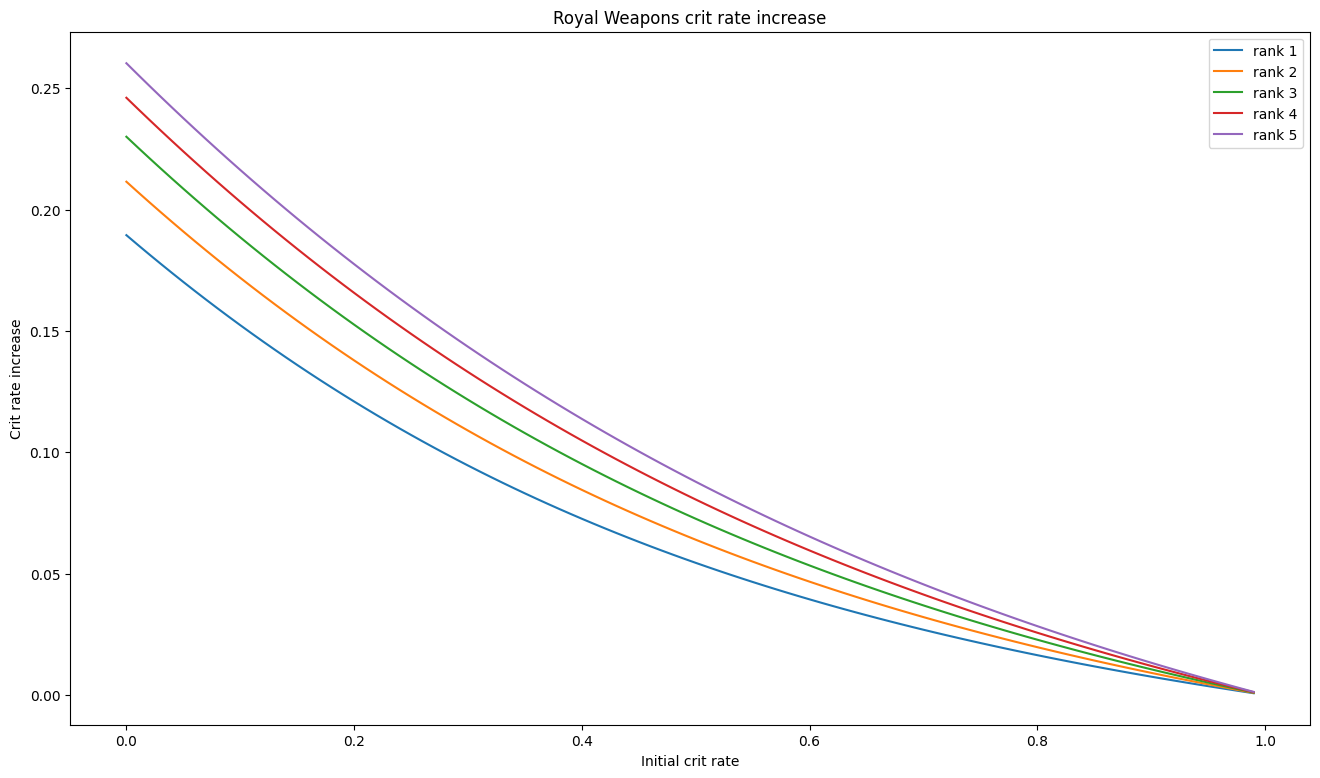

In [52]:
fig, ax = plt.subplots(figsize=(16, 9))
for label in results:
    ax.plot(domain, results[label], label=label)
ax.legend()

ax.set_title("Royal Weapons crit rate increase")
ax.set_xlabel("Initial crit rate")
ax.set_ylabel("Crit rate increase")

Note that the steady state results match with the simulation results,
so, we found an algebraic equation to calculate the crit rate 
provided by the passive of Royal Series without having to run simulations
or making approximations. This equation is:

In [53]:
print(E)
E

(5*p + r)/(6*p**4*r - 6*p**4 + 11*p**3*r**2 - 26*p**3*r + 15*p**3 + 6*p**2*r**3 - 24*p**2*r**2 + 33*p**2*r - 15*p**2 + p*r**4 - 6*p*r**3 + 15*p*r**2 - 20*p*r + 15*p + 1)


(5*p + r)/(6*p**4*r - 6*p**4 + 11*p**3*r**2 - 26*p**3*r + 15*p**3 + 6*p**2*r**3 - 24*p**2*r**2 + 33*p**2*r - 15*p**2 + p*r**4 - 6*p*r**3 + 15*p*r**2 - 20*p*r + 15*p + 1)

Where $r$ is the initial crit rate, and $p$ is the passive crit rate increase per stack.

## 3. Conclusion

We have described how the Royal passive behaves in terms of crit rate, 
and as the graph shows, the gain in crit rate gets smaller as the
initial crit rate increases.

For example, if the initial crit rate is 50%, the passive at R1 will increase
the crit rate by 5.4% at average, but if the initial crit rate is 80%, the 
passive at R1 will only increase the crit rate by 1.6% at average.

Also, we have found an algebraic equation to calculate the crit rate,
the idea of this is to copy the equation into the calculator to
get better results when optimizing damage with this weapons series.

In [54]:
royal_expr(0.5, 0.08) - 0.5

0.054423054063788

In [55]:
royal_expr(0.8, 0.08) - 0.8

0.016376219600762187

## 4. Further analysis

note that we're working in a range of possible values for the crit rate,
which is the logical thing to do, but there is a special case: Kokomi.

Since she has a "negative" crit rate it may behave differently. Values
below 0 are probabilistically equal to 0, but the difference is that
adding stacks will not actually increase the crit rate, at least
not until certain value and number of stacks.

This problem is analyzed in [this document](royal-negative.ipynb).